In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm



In [2]:
from google.colab import files
files.upload()  # select kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"namrahkhandurrani","key":"837302267d31f2c297ca141ed2967d15"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
# Download dataset from Kaggle
!kaggle datasets download -d mykola/gtsrb-german-traffic-sign-recognition-benchmark


403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/datasets/metadata/mykola/gtsrb-german-traffic-sign-recognition-benchmark


In [5]:
!kaggle datasets list -s gtsrb


ref                                                                title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  -------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
meowmeowmeowmeowmeow/gtsrb-german-traffic-sign                     GTSRB - German Traffic Sign Recognition Benchmark    641568792  2018-11-25 18:12:34.427000         160614       1248  0.8235294        
harbhajansingh21/german-traffic-sign-dataset                       German Traffic Sign Dataset                          123621493  2023-07-11 04:21:24.180000           2943         38  1.0              
daniildeltsov/traffic-signs-gtsrb-plus-162-custom-classes          Traffic Signs (GTSRB plus 162 custom classes)      16274543717  2022-04-15 14:59:47.803000           1040         44  0.8

In [6]:
!mkdir -p data/GTSRB


In [7]:
# Download an alternative dataset from Kaggle
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
100% 609M/612M [00:01<00:00, 301MB/s]
100% 612M/612M [00:01<00:00, 411MB/s]


In [14]:
# Unzip downloaded file
!unzip -q gtsrb-german-traffic-sign.zip -d /content/data

In [15]:
DATA_PATH = "data/GTSRB"
TRAIN_DIR = os.path.join(DATA_PATH, "Train")
TEST_DIR = os.path.join(DATA_PATH, "Test")

print("Train directory:", TRAIN_DIR)
print("Classes found:", len(os.listdir(TRAIN_DIR)))

Train directory: data/GTSRB/Train
Classes found: 43


In [16]:
def load_data(data_dir, img_size=(32, 32)):
    images = []
    labels = []
    for class_id in tqdm(os.listdir(data_dir), desc="Loading classes"):
        class_path = os.path.join(data_dir, class_id)
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(int(class_id))

    return np.array(images), np.array(labels)

In [17]:
# Load raw integer labels
X, y = load_data(TRAIN_DIR)        # y shape → (N,)

# Split before one-hot encoding
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Normalize inputs
X_train = X_train.astype("float32") / 255.0
X_val   = X_val.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

#  One-hot encode ONCE, here (after split)
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 43)
y_val   = to_categorical(y_val, 43)
y_test  = to_categorical(y_test, 43)


Loading classes: 100%|██████████| 43/43 [00:06<00:00,  6.41it/s]


In [18]:
# Define CNN model architecture
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


def build_cnn_model(input_shape=(32, 32, 3), num_classes=43):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create model
model = build_cnn_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 822,603 (3.14 MB)

 Trainable params: 822,603 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks to prevent overfitting
early_stop = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint("best_traffic_sign_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, lr_reduce, checkpoint]
)

Epoch 1/10
1954/1961 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9743 - loss: 0.1040
Epoch 1: val_accuracy improved from -inf to 0.99541, saving model to best_traffic_sign_model.h5


1961/1961 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9743 - loss: 0.1041 - val_accuracy: 0.9954 - val_loss: 0.0176 - learning_rate: 0.0010
Epoch 2/10
1957/1961 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9729 - loss: 0.1123
Epoch 2: val_accuracy did not improve from 0.99541
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9729 - loss: 0.1123 - val_accuracy: 0.9916 - val_loss: 0.0408 - learning_rate: 0.0010
Epoch 3/10
1952/1961 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9765 - loss: 0.1021
Epoch 3: val_accuracy did not improve from 0.99541
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9765 - loss: 0.1021 - val_accuracy: 0.9923 - val_loss: 0.0263 - learning_rate: 0.0010
Epoch 4/10
1959/1961 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9737 - loss: 0.1122
Epoch 4: val_accuracy improved from 0.99541 to 0.99592, saving model to best_traffic_sign_model.h5


1961/1961 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9737 - loss: 0.1122 - val_accuracy: 0.9959 - val_loss: 0.0136 - learning_rate: 0.0010
Epoch 5/10
1948/1961 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9734 - loss: 0.1175
Epoch 5: val_accuracy did not improve from 0.99592
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9734 - loss: 0.1175 - val_accuracy: 0.9952 - val_loss: 0.0205 - learning_rate: 0.0010
Epoch 6/10
1955/1961 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9720 - loss: 0.1260
Epoch 6: val_accuracy did not improve from 0.99592
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9720 - loss: 0.1261 - val_accuracy: 0.9939 - val_loss: 0.0291 - learning_rate: 0.0010
Epoch 7/10
1956/1961 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9750 - loss: 0.1211
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 7: val_accuracy did not improve from 0.99592
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9750 - loss: 0.1212 

1961/1961 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9821 - loss: 0.0740 - val_accuracy: 0.9974 - val_loss: 0.0128 - learning_rate: 5.0000e-04
Epoch 9/10
1954/1961 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9872 - loss: 0.0557
Epoch 9: val_accuracy did not improve from 0.99745
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9872 - loss: 0.0557 - val_accuracy: 0.9962 - val_loss: 0.0202 - learning_rate: 5.0000e-04
Epoch 10/10
1955/1961 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9871 - loss: 0.0603
Epoch 10: val_accuracy did not improve from 0.99745
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9871 - loss: 0.0603 - val_accuracy: 0.9974 - val_loss: 0.0150 - learning_rate: 5.0000e-04


In [32]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=False
)

datagen.fit(X_train)

history_aug = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=5,
    validation_data=(X_val, y_val)
)


Epoch 1/5
  4/981 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9531 - loss: 0.2131

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.9427 - loss: 0.2683 - val_accuracy: 0.9987 - val_loss: 0.0063
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.9565 - loss: 0.1868 - val_accuracy: 0.9977 - val_loss: 0.0067
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.9639 - loss: 0.1609 - val_accuracy: 0.9980 - val_loss: 0.0069
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9695 - loss: 0.1296 - val_accuracy: 0.9985 - val_loss: 0.0078
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.9721 - loss: 0.1210 - val_accuracy: 0.9992 - val_loss: 0.0053


In [21]:
import gc
gc.collect()

import torch
torch.cuda.empty_cache()

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0046
Validation Accuracy: 0.9992
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       1.00      1.00      1.00       222
           2       1.00      1.00      1.00       225
           3       1.00      1.00      1.00       141
           4       1.00      1.00      1.00       198
           5       1.00      0.99      1.00       186
           6       1.00      1.00      1.00        42
           7       0.99      1.00      1.00       144
           8       1.00      1.00      1.00       141
           9       1.00      1.00      1.00       147
          10       1.00      1.00      1.00       201
          11       1.00      1.00      1.00       132
          12       1.00      1.00      1.00       210
          13       1.00      1.00      1.00       216
          14       1.00      1.00      1.00  

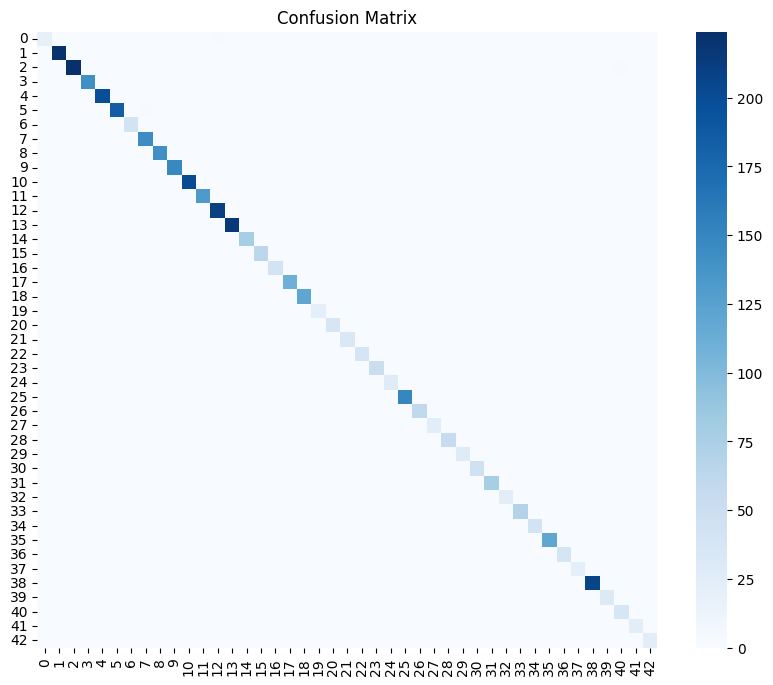

In [33]:
# Evaluate accuracy
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.4f}")

# Predict on validation set
y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification report
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap='Blues', annot=False)
plt.title("Confusion Matrix")
plt.show()



In [34]:
# Resize training and test images for MobileNet
import tensorflow as tf

X_train_resized = tf.image.resize(X_train, [96, 96])
X_val_resized = tf.image.resize(X_val, [96, 96])
X_test_resized = tf.image.resize(X_test, [96, 96])


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(43, activation='softmax')(x)

model_mobilenet = Model(inputs=base_model.input, outputs=output)


for layer in base_model.layers[-40:]:  # unfreeze last 40 layers
    layer.trainable = True

model_mobilenet.compile(optimizer=Adam(learning_rate=1e-5),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

history_finetune = model_mobilenet.fit(
    datagen.flow(X_train_resized, y_train, batch_size=32),
    epochs=5,
    validation_data=(X_val_resized, y_val),
    verbose=1
)

In [25]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print(type(X_test), type(y_test))


X_test shape: (3921, 32, 32, 3)
y_test shape: (3921, 43)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [26]:
# Evaluate custom CNN
cnn_loss, cnn_acc = model.evaluate(X_test, y_test)

# Evaluate MobileNet
mobilenet_loss, mobilenet_acc = model_mobilenet.evaluate(X_test, y_test)

print(f"Custom CNN Accuracy: {cnn_acc:.4f}")
print(f"MobileNetV2 Accuracy: {mobilenet_acc:.4f}")


123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9956 - loss: 0.0147
123/123 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.0482 - loss: 4.3715
Custom CNN Accuracy: 0.9967
MobileNetV2 Accuracy: 0.0492


123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step


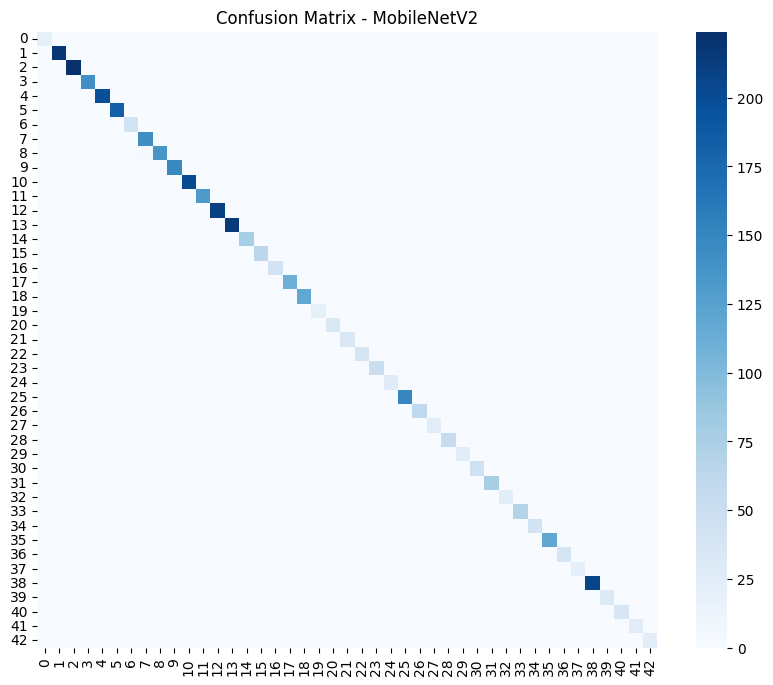

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       1.00      0.98      0.99       222
           2       0.98      1.00      0.99       225
           3       1.00      1.00      1.00       141
           4       0.99      1.00      1.00       198
           5       0.99      0.98      0.98       186
           6       1.00      1.00      1.00        42
           7       0.97      0.99      0.98       144
           8       0.95      0.96      0.96       141
           9       1.00      1.00      1.00       147
          10       1.00      1.00      1.00       201
          11       0.99      1.00      1.00       132
          12       1.00      1.00      1.00       210
          13       1.00      1.00      1.00       216
          14       1.00      1.00      1.00        78
          15       1.00      1.00      1.00        63
          16       1.00      1.00      1.00        42
          17       1.00    

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# Resize X_test to match MobileNetV2 input shape
X_test_resized = tf.image.resize(X_test, [96, 96])

y_pred = model_mobilenet.predict(X_test_resized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap='Blues', annot=False)
plt.title('Confusion Matrix - MobileNetV2')
plt.show()

print(classification_report(y_true, y_pred_classes))